# Imports
Versions <br>
python - 3.6.7 <br>
Pandas - 0.23.4 <br>
Biopython - 1.73 <br>
Scipy - 1.2.0 <br>
iupred2d - https://iupred2a.elte.hu/download <br>

In [3]:
import os
import ntpath
import datetime
import pandas as pd
from Bio import SeqIO
#信号处理
from scipy import signal
#计算蛋白质序列每个位置的内在无序得分
#在UIPred2A中得分高于0.5、0.6、0.7、0.8和0,9的氨基酸的比例
import iupred2a_lib
#计算每种氨基酸的百分比、长度、等电点、分子量、肉汤、芳香性以及alpha螺旋、beta转角和beta薄片的分数
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from tqdm.auto import tqdm

from multiprocessing import Pool
# Windows
CWD = os.getcwd()

e:\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Statics

In [2]:
pip install biopython

     ---------------------------------------- 2.7/2.7 MB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
RESIDUES = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
            'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Kyte & Doolittle {kd} index of hydrophobicity
HP = {'A': 1.8, 'R':-4.5, 'N':-3.5, 'D':-3.5, 'C': 2.5,
      'Q':-3.5, 'E':-3.5, 'G':-0.4, 'H':-3.2, 'I': 4.5,
      'L': 3.8, 'K':-3.9, 'M': 1.9, 'F': 2.8, 'P':-1.6,
      'S':-0.8, 'T':-0.7, 'W':-0.9, 'Y':-1.3, 'V': 4.2, 'U': 0.0}

# Classes

In [3]:
import time
#
class IuPred:
    def __init__(self, glob, short, long):
        self.glob = glob
        self.short = short
        self.long = long


class HydroPhobicIndex:
    def __init__(self, hpilist):
        self.hpilist = hpilist
        
def calc_idrpred(args):
    idx, seq = args
    glob = iupred2a.iupred(str(seq), 'glob')
    short = iupred2a.iupred(str(seq), 'short')
    long = iupred2a.iupred(str(seq), 'long')
    idrpred = IuPred(glob, short, long)
    return idx, idrpred
        

class MakeMatrix:
    def __init__(self, dbfasta):  
        self.df = pd.DataFrame()
        executables = [
             'self.fasta2df(dbfasta)',
             'self.amino_acid_analysis()',
             'self.idr_iupred()',
             'self.hydrophobic()',
             'self.add_iupred_features()',
             'self.add_hydrophobic_features()',
             'self.add_biochemical_combinations()',
             'self.add_lowcomplexity_features()' ,
            # 'self.add_plaac()'
        ]        
        for e in executables:
            start = time.time()     
            print(e)
            exec(e)
            end = time.time()        
            print(str(round(end - start, 2))+'s '+e)

    def fasta2df(self, dbfasta):
        rows = list()
        with open(dbfasta) as f:
            #读取包含多个序列的fasta格式文件
            for record in SeqIO.parse(dbfasta, 'fasta'):
                seqdict = dict()
                seq = str(record.seq)
                id = record.description.split('|')                
                if id[0] == 'sp':
                    uniprot_id = id[1]
                    name = id[2].split(' ')[0]
                    rows.append([name, uniprot_id, seq])
                elif id[0] == 'tr':
                    uniprot_id = id[1]
                    name = id[2].split(' ')[0]
                    rows.append([name, uniprot_id, seq])
                else:
                    uniprot_id = id[0]
                    name = id[2].split(' ')[0]
                    rows.append([name, uniprot_id, seq])                    
        self.df = pd.DataFrame(rows, columns=['protein_name', 'uniprot_id', 'sequence'])
        print(len(self.df))#返回序列的个数

#     def set_identifiers(self, fastas):
#         self.df['llps'] = 0
#         for i in fastas:
#             fname = ntpath.basename(i).split('.')[0]
#             self.df[fname] = 0
#             with open(i) as f:
#                 for record in SeqIO.parse(f, 'fasta'):
#                     id_split = record.id.split('|')
#                     protid = (id_split[1])
#                     self.df.loc[self.df['uniprot_id'] == protid, fname] = 1
#                     self.df.loc[self.df['uniprot_id'] == protid, 'llps'] = 1
    #无序区
    def idr_iupred(self):
        self.df['iupred'] = object
        data = list(self.df["sequence"].iteritems())
        p = Pool(32)
        for idx, idrpred in tqdm(p.imap(calc_idrpred, data), total=self.df.shape[0]):
            self.df.at[idx, 'iupred'] = idrpred
        for index, row in tqdm(self.df.iterrows(), total=self.df.shape[0]):
            for index, row in self.df.iterrows():
                 seq = row['sequence']
                 glob = iupred2a.iupred(str(seq), 'glob')
                 short = iupred2a.iupred(str(seq), 'short')
                 long = iupred2a.iured(str(seq), 'long')
                 idrpred = IuPred(glob, short, long)
                 self.df.at[index, 'iupred'] = idrpred
     #疏水性       
    def hydrophobic(self):
        for index, row in self.df.iterrows():
            hpilst = pd.Series(list(row['sequence'])).map(HP).tolist()
            self.df.loc[index, 'HydroPhobicIndex'] = HydroPhobicIndex(hpilst)
    #氨基酸分析        
    def amino_acid_analysis(self):
        for res in RESIDUES:
            self.df['fraction_'+res] = self.df['sequence'].str.count(res) / self.df['sequence'].str.len()
        self.df['length'] = self.df['sequence'].str.len()
        for index, row in tqdm(self.df.iterrows(), total=self.df.shape[0]):
        #for index, row in self.df.iterrows():
            seq = row['sequence']   
            seqanalysis = ProteinAnalysis(seq)
            acidist = seqanalysis.get_amino_acids_percent() 
            self.df.loc[index, 'IEP'] = seqanalysis.isoelectric_point()
            if 'X' not in seq and 'B' not in seq:
                self.df.loc[index, 'molecular_weight'] = seqanalysis.molecular_weight()
            if 'U' not in seq and 'X' not in seq and 'B' not in seq:
                self.df.loc[index, 'gravy'] = seqanalysis.gravy()
          
    #计算了在UIPred2A中得分高于0.5、0.6、0.7、0.8和0,9的氨基酸的比例
    def add_iupred_features(self):
        for index, row in tqdm(self.df.iterrows(), total=self.df.shape[0]):
        #for index, row in self.df.iterrows():
            idr = row['iupred'].glob[0]
            self.df.loc[index, 'idr_percetage'] = sum(i > .5 for i in list(idr))
            self.df.loc[index, 'idr_50'] = sum(i > .5 for i in list(idr)) / len(str(row['sequence']))
            self.df.loc[index, 'idr_60'] = sum(i > .6 for i in list(idr)) / len(str(row['sequence']))
            self.df.loc[index, 'idr_70'] = sum(i > .7 for i in list(idr)) / len(str(row['sequence']))
            self.df.loc[index, 'idr_80'] = sum(i > .8 for i in list(idr)) / len(str(row['sequence']))
            self.df.loc[index, 'idr_90'] = sum(i > .9 for i in list(idr)) / len(str(row['sequence']))

    def add_hydrophobic_features(self):
        #浮点数类型的列表 存储蛋白质的kyte/doolittle分数
        hpi0, hpi1, hpi2, hpi3, hpi4, hpi5 = list(), list(), list(), list(), list(), list() 
        for index, row in tqdm(self.df.iterrows(), total=self.df.shape[0]):
        #for index, row in self.df.iterrows():
            sw = convolve_signal(row['HydroPhobicIndex'].hpilist, window=30)#Hann窗口为30
            #在卷积表中计算一个蛋白质序列中得分低于1.5、2.0或2.5的氨基酸的分数和总数
            hpi0.append(sum(i < -1.5 for i in sw) / len(sw))
            # self.df.loc[index, 'hpi_<-1.5_frac'] = hpi
            hpi1.append(sum(i < -2.0 for i in sw) / len(sw))
            # self.df.loc[index, 'hpi_<-2.0_frac'] = hpi
            hpi2.append(sum(i < -2.5 for i in sw) / len(sw))
            # self.df.loc[index, 'hpi_<-2.5_frac'] = hpi
            hpi3.append(sum(i < -1.5 for i in sw))
            # self.df.loc[index, 'hpi_<-1.5'] = hpi
            hpi4.append( sum(i < -2.0 for i in sw))
            # self.df.loc[index, 'hpi_<-2.0'] = hpi
            hpi5.append(sum(i < -2.5 for i in sw))
            # self.df.loc[index, 'hpi_<-2.5'] = hpi 
        self.df['hpi_<-1.5_frac'] = hpi0
        self.df['hpi_<-2.0_frac'] = hpi1
        self.df['hpi_<-2.5_frac'] = hpi2
        self.df['hpi_<-1.5'] = hpi3
        self.df['hpi_<-2.0'] = hpi4
        self.df['hpi_<-2.5'] = hpi5
            
 
    def add_biochemical_combinations(self):
        df = self.df
        #氨基酸组合被分组为:Asx: D, N, Glx: E, Q, Xle: I, L，正电荷:K, R, H，负电荷:D, E，
        #芳香:F, W, Y, H，脂肪族:V, I, L, M，小:P, G, A, S，亲水:S, T, H, N, Q, E, D, K, R，疏水:V, I, L, F, W, Y, M。
        df = df.assign(Asx=df['fraction_D'] + df['fraction_N'])
        df = df.assign(Glx=df['fraction_E'] + df['fraction_Q'])
        df = df.assign(Xle=df['fraction_I'] + df['fraction_L'])
        df = df.assign(Pos_charge=df['fraction_K'] + df['fraction_R'] + df['fraction_H'])
        df = df.assign(Neg_charge=df['fraction_D'] + df['fraction_E'])
        df = df.assign(Aromatic=df['fraction_F'] + df['fraction_W'] + df['fraction_Y'] + df['fraction_H'])
        df = df.assign(Alipatic=df['fraction_V'] + df['fraction_I'] + df['fraction_L'] + df['fraction_M'])
        df = df.assign(Small=df['fraction_P'] + df['fraction_G'] + df['fraction_A'] + df['fraction_S'])
        df = df.assign(Hydrophilic=(df['fraction_S'] + df['fraction_T'] + df['fraction_H'] + 
                                    df['fraction_N'] + df['fraction_Q'] + df['fraction_E'] +
                                    df['fraction_D'] + df['fraction_K'] + df['fraction_R']))
        df = df.assign(Hydrophobic= (df['fraction_V'] + df['fraction_I'] + df['fraction_L'] +
                                     df['fraction_F'] + df['fraction_W'] + df['fraction_Y'] +
                                     df['fraction_M']))
        
        # Added in version 2
        for dimer in ['GV', 'VG', 'VP', 'PG', 'FG', 'RG', 'GR', 'GG', 'YG', 'GS', 'SG', 'GA', 'GF', 'GD', 'DS']:
            self.df[dimer] = self.df['sequence'].str.count(dimer)
        df = df.assign(alpha_helix=df['fraction_V'] + df['fraction_I'] + df['fraction_Y'] + df['fraction_F']
                      + df['fraction_W'] + df['fraction_L'])
        df = df.assign(beta_turn=df['fraction_N'] + df['fraction_P'] + df['fraction_G'] + df['fraction_S'])
        df = df.assign(beta_sheet=df['fraction_E'] + df['fraction_M'] + df['fraction_A'] + df['fraction_L'])
        #Calculates the aromaticity value of a protein according to Lobry, 1994. 
        # It is simply the relative frequency of Phe+Trp+Tyr.
        df = df.assign(aromaticity=df['fraction_F'] + df['fraction_W'] + df['fraction_Y'])

        
        
        
        self.df = df
        del df
    #低复杂度的得分
    def add_lowcomplexityscore(self):
        #对这两个变量进行网格搜索，以找到PPS阳性和阴性样本之间的最低p值。
        lcs_window = 20#滑动窗口：20
        lcs_cutoff = 7#独特的氨基酸《7
        for index, row in self.df.iterrows():
            seq = str(row['sequence'])
            if len(seq) > lcs_window+1:
                sig = list()
                for i in range(len(seq)):
                    window = (seq[i: i+lcs_window])
                    if len(window) == lcs_window:
                        acid_comp = len(list(set(window)))
                        sig.append(acid_comp)
                score = sum([1 if i <= 7 else 0 for i in sig])#对于每个氨基酸都创建一个窗口，当标准满足窗口时，窗口中间的氨基酸得到1分，否则为0分
                self.df.loc[index, 'lcs_score'] = score
                self.df.loc[index, 'lcs_fraction'] = score / len(sig)#最终的分数除以蛋白质的长度得到总复杂度分数
                
    #对于每个氨基酸都创建一个窗口，当标准满足窗口时，窗口中间的氨基酸得到1分，否则为0分。            
    def add_lowcomplexity_features(self):
        n_window = 20
        cutoff = 7       
        n_halfwindow = int(n_window / 2)        
        lcs_lowest_complexity = list()
        lcs_scores = list()
        lcs_fractions = list()
        for index, row in tqdm(self.df.iterrows(), total=self.df.shape[0]):
        #for index, row in self.df.iterrows():            
            # Determine low complexity scores
            seq = str(row['sequence'])
            lcs_acids = list()
            sig = list()
            
            # New
            lc_bool = [False] * len(seq)
            for i in range(len(seq)):
                if i < n_halfwindow:
                    peptide = seq[:n_window]        
                elif i+n_halfwindow > int(len(seq)):
                    peptide = seq[-n_window:]        
                else:
                    peptide = seq[i-n_halfwindow:i+n_halfwindow]       
                complexity = (len(set(peptide)))
                if complexity <= 7:
                    for bool_index in (i-n_halfwindow, i+n_halfwindow):
                        try:
                            lc_bool[bool_index] = True
                        except IndexError:
                            pass
                    lcs_acids.append(seq[i])
                sig.append(complexity)            
            # Adding low complexity scores to list
            low_complexity_list = pd.DataFrame({'bool':lc_bool, 'acid':list(seq)}, index=None)
            lcs_lowest_complexity.append(min(sig))
            lcs_scores.append(len(low_complexity_list.loc[low_complexity_list['bool'] == True]))
            lcs_fractions.append(len(low_complexity_list.loc[low_complexity_list['bool'] == True]) / len(seq))
            low_complexity_list = pd.DataFrame({'bool':lc_bool, 'acid':list(seq)}, index=None)
            if len(lcs_acids) >= n_window:
                for i in RESIDUES:
                    self.df.loc[index ,i+'_lcscore'] = (len(low_complexity_list.loc[
                        (low_complexity_list['bool'] == True) &
                        (low_complexity_list['acid'] == i)])
                    )
                    self.df.loc[index ,i+'_lcfraction'] = (len(low_complexity_list.loc[
                        (low_complexity_list['bool'] == True) & 
                        (low_complexity_list['acid'] == i)]) / len(lcs_acids)
                    )
        self.df['lcs_fractions'] = lcs_fractions
        self.df['lcs_scores'] = lcs_scores
        self.df['lcs_lowest_complexity'] = lcs_lowest_complexity
        
    def add_plaac(self):
        plaac = CWD+'/data/plaac/plaac_swissprot140219.tsv'
        plaac = pd.read_csv(plaac, sep='\t')
        plaac[['database', 'accession', 'name']] = plaac['SEQid'].str.split('|',expand=True)
        plaac = plaac.drop(['SEQid', 'database', 'name', 'PAPAaa', 'STARTaa', 
                            'ENDaa', 'COREaa', 'MW', 'MWstart', 'MWend', 'MWlen'], axis=1)
        self.df = pd.merge(self.df, plaac, left_on='uniprot_id', right_on='accession')
        self.df = self.df.drop('accession', axis=1)


def convolve_signal(sig, window=25):
    win = signal.hann(window)
    sig = signal.convolve(sig, win, mode='same') / sum(win)
    return sig


def average(l):
    return sum(l) / len(l)

In [4]:
def main(name, fasta_path, operating_system='Windows'):
    # Change pathing
    """ Generates and saves a file which contains features of a protein sequence.
    Parameters:
        name: Name of the file.
        fasta_path: Path of the fasta file which needs to be featured.
        operating_system: String which indicates which operating system is used only 'Windows' available.
        生成并保存包含蛋白质序列特征的文件。
        参数：
        name：文件的名称。
        fasta_path：需要使用的fasta文件的路径。
        operating_system：字符串，表示只使用“Windows”可用的操作系统。

    """
    data = MakeMatrix(fasta_path)   
    now = datetime.datetime.now()
    date = (str(now.day) + '-' + str(now.month)  + '-' +  str(now.year))
    #if operating_system == 'Windows':
    data.df.to_pickle('data/Dataframes/'+ name + '_llps_f2f_' + date + '.pkl')
    print('Generated file: ' + name + '_llps_f2f_' + date + '.pkl')
    return data.df

# Homo sapiens

In [ ]:
human_proteome_path = CWD+'/fasta/test.fasta'
df = main(name='test', fasta_path=human_proteome_path)

In [1]:
data=pd.read_pickle("D:/jupyter_file/iupred2a/data/Dataframes/test_llps_f2f_14-11-2022.pkl")

NameError: name 'pd' is not defined

In [11]:
df

,protein_name,uniprot_id,sequence,fraction_A,fraction_C,fraction_D,fraction_E,fraction_F,fraction_G,fraction_H,...,T_lcfraction,V_lcscore,V_lcfraction,W_lcscore,W_lcfraction,Y_lcscore,Y_lcfraction,lcs_fractions,lcs_scores,lcs_lowest_complexity
0,DDX3_CAEEL,D0PV95,MESNQSNNGGSGNAALNRGGRYVPPHLRGGDGGAAAAASAGGDDRR...,0.056497,0.005650,0.072034,0.052260,0.028249,0.182203,0.014124,...,0.006757,0.0,0.000000,2.0,0.013514,11.0,0.074324,0.295198,209,4
1,PGL3_CAEEL,G5EBV6,MEANKRQIVEVDGIKSYFFPHLAHYLASNDELLVNNIAQANKLAAF...,0.086580,0.005772,0.056277,0.080808,0.046176,0.088023,0.010101,...,0.018182,0.0,0.000000,0.0,0.000000,5.0,0.090909,0.093795,65,5
2,PLK4_HUMAN,O00444,MATCIGEKIEDFKVGNLLGKGSFAGVYRAESIHTGLEVAIKMIDKK...,0.050515,0.013402,0.046392,0.058763,0.038144,0.055670,0.028866,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016495,16,6
3,DDX3X_HUMAN,O00571,MSHVAVENALGLDQQFAGLDLNSSDNQSGGSTASKGRYIPPHLRNR...,0.055891,0.010574,0.072508,0.061934,0.046828,0.114804,0.021148,...,0.000000,1.0,0.014493,0.0,0.000000,7.0,0.101449,0.170695,113,5
4,DCP2_SCHPO,O13828,MSFTNATFSQVLDDLSARFILNLPAEEQSSVERLCFQIEQAHWFYE...,0.045884,0.008097,0.055331,0.053981,0.044534,0.031039,0.022942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029690,22,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,TPX2_HUMAN,Q9ULW0,MSQVKSSYSYDAPSDFINFSSLDDEGDTQNIDSWFEEKANLENKLL...,0.060241,0.014726,0.037483,0.116466,0.037483,0.029451,0.022758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.040161,30,6
103,G3BP2_HUMAN,Q9UN86,MVMEKPSPLLVGREFVRQYYTLLNKAPEYLHRFYGRNSSYVHGGVD...,0.035270,0.002075,0.047718,0.120332,0.039419,0.095436,0.026971,...,0.071429,3.0,0.053571,0.0,0.000000,0.0,0.000000,0.211618,102,6
104,YTHD2_HUMAN,Q9Y5A9,MSASSLLEQRPKGQGNKVQNGSVHQKDGLNDDDFEPYLSPQARPNN...,0.079447,0.005181,0.044905,0.036269,0.032815,0.096718,0.022453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.056995,33,6
105,TACC3_HUMAN,Q9Y6A5,MSLQVLNDKNVSNEKNTENCDFLFSPPEVTGRSSVLRVSQKENVPP...,0.091885,0.017900,0.048926,0.108592,0.021480,0.069212,0.019093,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019093,16,7


In [31]:
df[df["protein_name"]=="PLK4_HUMAN"]

,protein_name,uniprot_id,sequence
2,PLK4_HUMAN,O00444,MATCIGEKIEDFKVGNLLGKGSFAGVYRAESIHTGLEVAIKMIDKK...


In [32]:
df[df["protein_name"] == "YBX1_HUMAN"]

,protein_name,uniprot_id,sequence


In [22]:
!egrep ">.*TFG" data/fasta/UP000005640_9606.fasta

'egrep' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [23]:
/data/fasta/UP000005640_9606.fasta

NameError: name 'data' is not defined

In [24]:
help(ntpath.basename)

Help on function basename in module ntpath:

basename(p)
    Returns the final component of a pathname



In [6]:
import ntpath

In [7]:
help(ntpath.basename)

Help on function basename in module ntpath:

basename(p)
    Returns the final component of a pathname



In [8]:
help(ntpath.isabs)

Help on function isabs in module ntpath:

isabs(s)
    Test whether a path is absolute



In [9]:
help(ntpath.dirname)

Help on function dirname in module ntpath:

dirname(p)
    Returns the directory component of a pathname



In [10]:
help(ntpath.normpath)

Help on function normpath in module ntpath:

normpath(path)
    Normalize path, eliminating double slashes, etc.



In [12]:
from scipy import signal

In [13]:
help(signal.hann)

Help on function hann in module scipy.signal:

hann(*args, **kwargs)
    Return a Hann window.
    
    The Hann window is a taper formed by using a raised cosine or sine-squared
    with ends that touch zero.
    
    .. warning:: scipy.signal.hann is deprecated,
                 use scipy.signal.windows.hann instead.
    
    Parameters
    ----------
    M : int
        Number of points in the output window. If zero or less, an empty
        array is returned.
    sym : bool, optional
        When True (default), generates a symmetric window, for use in filter
        design.
        When False, generates a periodic window, for use in spectral analysis.
    
    Returns
    -------
    w : ndarray
        The window, with the maximum value normalized to 1 (though the value 1
        does not appear if `M` is even and `sym` is True).
    
    Notes
    -----
    The Hann window is defined as
    
    .. math::  w(n) = 0.5 - 0.5 \cos\left(\frac{2\pi{n}}{M-1}\right)
               \qqu

In [14]:
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt

In [16]:
window=signal.windows.hann(51)

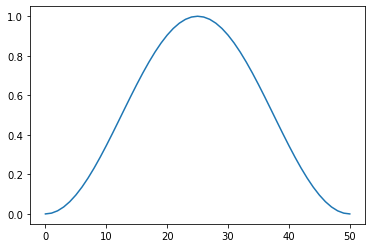

In [17]:
plt.plot(window)

Text(0.5, 0, 'Sample')

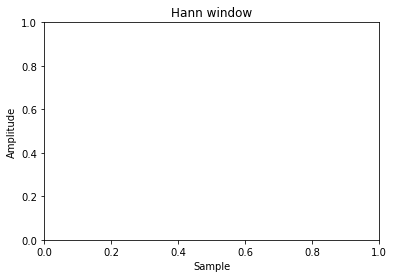

In [18]:
plt.title("Hann window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

In [19]:
help(signal.convolve)

Help on function convolve in module scipy.signal.signaltools:

convolve(in1, in2, mode='full', method='auto')
    Convolve two N-dimensional arrays.
    
    Convolve `in1` and `in2`, with the output size determined by the
    `mode` argument.
    
    Parameters
    ----------
    in1 : array_like
        First input.
    in2 : array_like
        Second input. Should have the same number of dimensions as `in1`.
    mode : str {'full', 'valid', 'same'}, optional
        A string indicating the size of the output:
    
        ``full``
           The output is the full discrete linear convolution
           of the inputs. (Default)
        ``valid``
           The output consists only of those elements that do not
           rely on the zero-padding. In 'valid' mode, either `in1` or `in2`
           must be at least as large as the other in every dimension.
        ``same``
           The output is the same size as `in1`, centered
           with respect to the 'full' output.
    method

In [20]:
import numpy as np

In [21]:
help(np.repeat)

Help on function repeat in module numpy:

repeat(a, repeats, axis=None)
    Repeat elements of an array.
    
    Parameters
    ----------
    a : array_like
        Input array.
    repeats : int or array of ints
        The number of repetitions for each element.  `repeats` is broadcasted
        to fit the shape of the given axis.
    axis : int, optional
        The axis along which to repeat values.  By default, use the
        flattened input array, and return a flat output array.
    
    Returns
    -------
    repeated_array : ndarray
        Output array which has the same shape as `a`, except along
        the given axis.
    
    See Also
    --------
    tile : Tile an array.
    unique : Find the unique elements of an array.
    
    Examples
    --------
    >>> np.repeat(3, 4)
    array([3, 3, 3, 3])
    >>> x = np.array([[1,2],[3,4]])
    >>> np.repeat(x, 2)
    array([1, 1, 2, 2, 3, 3, 4, 4])
    >>> np.repeat(x, 3, axis=1)
    array([[1, 1, 1, 2, 2, 2],
           [

In [22]:
x=np.array([[1,2],[3,4]])

In [23]:
x

array([[1, 2],
       [3, 4]])

In [35]:
b=np.repeat(x,[1,2],axis=1)

In [36]:
b.shape

(2, 3)

In [28]:
a.shape

NameError: name 'a' is not defined

In [29]:
x.shape

(2, 2)

In [31]:
x

array([[1, 2],
       [3, 4]])

In [37]:
b

array([[1, 2, 2],
       [3, 4, 4]])

In [38]:
sig = np.repeat([0., 1., 0.], 100)

In [39]:
sig

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.